<a href="https://colab.research.google.com/github/alolszewski/Caesar-FFR-Calculations/blob/main/Caesar_FFR_Calculations_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install reliability==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# # run if errors occur with matplotlib importing _png
# !pip uninstall matplotlib
# !pip install matplotlib==3.1.3

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
import pandas as pd
import os.path
import os
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

In [5]:
from reliability.Fitters import Fit_Weibull_3P
from reliability.Fitters import Fit_Weibull_2P
from reliability.Fitters import Fit_Exponential_1P
from reliability.Other_functions import histogram
from reliability import Distributions
from reliability.Other_functions import stress_strength
from reliability.Other_functions import crosshairs
from reliability.Distributions import Weibull_Distribution
from reliability.Probability_plotting import plot_points
from reliability.Fitters import Fit_Everything
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution

In [6]:
#fix dark mode for Ed 
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1), 
})


In [7]:
def fileparse(file):
    df = pd.read_csv(file, sep=',',header=0, index_col=0)
    print("parsed 1 file")
    #print(df.head())
    return df

In [8]:
def SF_CI_func(fit_obj,side='lower'):
    df=fit_obj.percentiles
    df['SF']=(100-df['Percentile'])/100
    if side == 'lower':
        return interp1d(df['Lower Estimate'], df['SF'], fill_value=(1,0), bounds_error=False)
    if side =='upper':
        return interp1d(df['Upper Estimate'], df['SF'], fill_value=(1,0), bounds_error=False)
    
def PDF_CI_func(fit_obj,side='lower'):
    df=fit_obj.percentiles
    df['SF']=(100-df['Percentile'])/100
    df['PDF_lower']=-(df['SF']-df['SF'].shift(1))/(df['Lower Estimate']-df['Lower Estimate'].shift(1))
    df['PDF_upper']=-(df['SF']-df['SF'].shift(1))/(df['Upper Estimate']-df['Upper Estimate'].shift(1))
    df['PDF_upper'].iloc[0]=0
    df['PDF_lower'].iloc[0]=0
    if side == 'lower':
        return interp1d(df['Lower Estimate'], df['PDF_lower'], fill_value=(0,0), bounds_error=False)
    if side =='upper':
        return interp1d(df['Upper Estimate'], df['PDF_upper'], fill_value=(0,0), bounds_error=False)

In [9]:
#let's make this into a function to be able to re-use it
#it should take in: a list of 
#stress(use) objects
#strength(failure) and  
#parameters, mainly for graphs 
#it should return: a list of attributes 

#first you fit the data yourself 
#then you use the function that extends stress-strength analysis
#it's your responsiblity to fit the data properly and to make sure
#that the usage data is scaled to the period in years before you fit it!

def stess_strength_extended(
    use_fit,
    use_data,
    failure_fit,
    failure_data,
    period_in_years,
    prd_hours_per_year,
    total_life,
    plot=True):
    
    strength = failure_fit.distribution
    stress = use_fit.distribution
    
    maxx=min(use_fit.percentiles['Upper Estimate'].iloc[-1], failure_fit.percentiles['Upper Estimate'].iloc[-1])
    x = np.linspace(0, maxx, num=10000, endpoint=True)
    
    #usage stuff
    lower_sf_func=SF_CI_func(use_fit,'lower')
    upper_sf_func=SF_CI_func(use_fit,'upper')
    stress.SF(xvals=x,show_plot=True,label='Usage')
    plt.plot(x,lower_sf_func(x),linestyle='--', color='#1f77b4', alpha=0.5)
    plt.plot(x,upper_sf_func(x),linestyle='--', color='#1f77b4', alpha=0.5)
    plt.xlabel('Hours of Use')
    
    #plt.show()
    
    #failure stuff
    
    #SF_CI_func
    lower_sf_func=SF_CI_func(failure_fit,'lower')
    upper_sf_func=SF_CI_func(failure_fit,'upper')
    

    failure_fit.distribution.SF(label='Failures',color='#ff7f0e')
    plt.plot(x,lower_sf_func(x),linestyle='--', color='#ff7f0e', alpha=0.5)
    plt.plot(x,upper_sf_func(x),linestyle='--', color='#ff7f0e', alpha=0.5)
    plt.xlim(0,total_life*prd_hours_per_year)
    plt.legend()
    plt.title('Survival in %0.0f Year Period' % period_in_years)
    plt.xlabel('Hours of Use')
    plt.show()
    
    #PDF_CI_func
#     lower_pdf_func=PDF_CI_func(failure_fit,'lower')
#     upper_pdf_func=PDF_CI_func(failure_fit,'upper')
    
#     failure_fit.distribution.PDF(label='Fitted Distribution',color='steelblue')

#     plt.plot(x,lower_pdf_func(x),linestyle='--', color='red')
#     plt.plot(x,upper_pdf_func(x),linestyle='--', color='blue')
#     plt.xlim(0,maxx)
#     plt.show()
    
    #strength = Distributions.Weibull_Distribution(alpha=200, beta=5, gamma=150)

    
    ss_failure = np.trapz(strength.PDF(x, show_plot=False) * stress.SF(x, show_plot=False), x)
    print('Stress-strength nominal failure = %0.1f%%' % (ss_failure*100))
    
    ss_failure_upper = np.trapz(PDF_CI_func(failure_fit,'lower')(x) * SF_CI_func(use_fit,'upper')(x), x)
    print('Stress-strength Upper CI failure = %0.1f%%' % (ss_failure_upper*100))

    ss_failure_lower = np.trapz(PDF_CI_func(failure_fit,'upper')(x) * SF_CI_func(use_fit,'lower')(x), x)
    print('Stress-strength Lower CI failure = %0.1f%%' % (ss_failure_lower*100))
    
    z = np.linspace(0, (period_in_years*prd_hours_per_year), num=1000, endpoint=True)
    rs_failure_whole_period = np.trapz(PDF_CI_func(failure_fit,'lower')(z), z)
    print('Reliability Statement for whole period = %0.1f%% failure rate' % (rs_failure_whole_period*100))
    
    z = np.linspace(0, (1*prd_hours_per_year), num=1000, endpoint=True)
    rs_failure_one_year = np.trapz(PDF_CI_func(failure_fit,'lower')(z), z)
    print('Reliability statement for one year = %0.1f%% failure rate' % (rs_failure_one_year*100))
    
    #stress-strength chart
    fig, ax = plt.subplots()
    stress_strength(stress=stress, strength=strength)
    
    bins=np.histogram_bin_edges(use_data, bins=20, range=None, weights=None)
    histogram(use_data,color='#1f77b4', alpha=0.5,bins=bins) 
    histogram(failure_data, color='#ff7f0e', alpha = 0.4,bins=bins)

    #plt.plot(x,PDF_CI_func(failure_fit,'lower')(x),linestyle='--', color='#ff7f0e')
    #plt.plot(x,PDF_CI_func(failure_fit,'upper')(x),linestyle='--', color='#ff7f0e')

    #plt.plot(x,PDF_CI_func(use_fit,'lower')(x),linestyle='--', color='#1f77b4')
    #plt.plot(x,PDF_CI_func(use_fit,'upper')(x),linestyle='--', color='#1f77b4')


    plt.title('Probability of Handlebar Strap Field Failure in %0.0f year period' % (period_in_years))
    plt.xlabel('Total Use in Hours')
    plt.xlim(0,total_life*prd_hours_per_year)
    ax.set_ylim(0,np.amax(np.concatenate([np.histogram(strap_failures,density=True)[0],np.histogram(usage,density=True)[0]])*1.2))
    labels=['Usage Distribution','Failure Distribution']
    plt.legend(labels)
    #plt.text(50,0.028,'Probability of Failure in Population = %0.2f%%' % (probability_of_failure*100))
    plt.show()
    
    #reliability statement chart
    fig, ax = plt.subplots()
    strength.SF(x, label='Falure PDF', color='#ff7f0e')
    
    x_pts=[1*prd_hours_per_year,1*prd_hours_per_year, 1*prd_hours_per_year, 0,
           period_in_years*prd_hours_per_year, period_in_years*prd_hours_per_year, period_in_years*prd_hours_per_year, 0]
    y_pts=[1,1-rs_failure_one_year, 1-rs_failure_one_year, 1-rs_failure_one_year,
          1,1-rs_failure_whole_period, 1-rs_failure_whole_period, 1-rs_failure_whole_period]

    #plt.axvline((period_in_years*prd_hours_per_year), color='k', linestyle='dashed', linewidth=1)
    #plt.axvline((1*prd_hours_per_year), color='k', linestyle='dashed', linewidth=1)
    #plt.axhline(1-rs_failure_one_year, color='k', linestyle='dashed', linewidth=1)
    #plt.axhline(1-rs_failure_whole_period, color='k', linestyle='dashed', linewidth=1)
    for i in range(0, len(x_pts), 2):
        plt.plot(x_pts[i:i+2], y_pts[i:i+2], color='k', linestyle='dashed', linewidth=1)

    
    plt.title('Survival Function')
    plt.xlabel('Total Use in Hours')
    plt.xlim(0,total_life*prd_hours_per_year)
    def hours2years(x):
        return x / prd_hours_per_year
    def years2hours(x):
        return x * prd_hours_per_year
    ax2 = ax.secondary_xaxis('top', functions=(hours2years, years2hours))
    ax2.set_xlabel('PRD Years')
    tick_spacing = 1
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    extraticks=[1-rs_failure_whole_period, 1-rs_failure_one_year]
    plt.yticks(list(plt.yticks()[0]) + extraticks)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
    ax.set_ylim(0,1)
    ax.grid(True)
    plt.show()
    
    #plot the usage PDF with percentile lines
    fig, ax = plt.subplots()
    use_fit.distribution.PDF(linestyle='--', label='Weibull Distribution Fit')
    line2 = pd.DataFrame (use_data)[0].quantile(q=0.75)
    line3 = pd.DataFrame (use_data)[0].quantile(q=0.95)

    plt.axvline(line2, color='k', linestyle='dashed', linewidth=1)
    plt.text(line2+1, 0.01,'75th percentile', rotation=0, fontsize=10)

    plt.axvline(line3, color='k', linestyle='dashed', linewidth=1)
    plt.text(line3+1, 0.01,'95th percentile' % line3, rotation=0, fontsize=10)
    extraticks=[line2,line3]
    plt.xticks(list(plt.xticks()[0]) + extraticks)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    histogram(use_data,color='#1f77b4', alpha=0.4) 
    plt.legend()
    ax.set_ylim(0,np.amax(np.histogram(use_data,density=True)[0])*2)
    plt.xlim(0,pd.DataFrame (use_data)[0].quantile(q=0.99))
    plt.xlabel('Hours of Use')
    plt.title('Distribution of Device Use in %0.0f Year Period' % period_in_years)

In [10]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [11]:
name_of_google_sheet = 'CaesarRELFailData_usagedata'

worksheet = gc.open(name_of_google_sheet).worksheet('use_data_bike')
rows = worksheet.get_all_values()
test_df=pd.DataFrame.from_records(rows[1::], columns=rows[0])
test_df = test_df.astype(float)

In [19]:
worksheet = gc.open(name_of_google_sheet).worksheet('PVT_Handlestrap')
rows = worksheet.get_all_values()
failure_df=pd.DataFrame.from_records(rows[1::], columns=rows[0])

failure_df['failures']=pd.to_numeric(failure_df['failures'],errors='coerce')
failure_df['non-failures']=pd.to_numeric(failure_df['non-failures'],errors='coerce')

failure_df= failure_df.astype(float,errors='ignore')

In [20]:
plt.rcParams['figure.figsize'] = [10.5, 5.25]
plt.rcParams['figure.dpi'] = 100

In [21]:
lower=np.linspace(0.00001,1,500, endpoint=False)
middle=np.linspace(1,99,1000, endpoint=False)
upper=np.linspace(99,99.99999,500, endpoint=False)

percentiles=(np.concatenate([np.asarray(lower), np.asarray(middle), np.asarray(upper)]))

In [22]:
percentiles

array([1.00000000e-05, 2.00998000e-03, 4.00996000e-03, ...,
       9.99939901e+01, 9.99959900e+01, 9.99979900e+01])

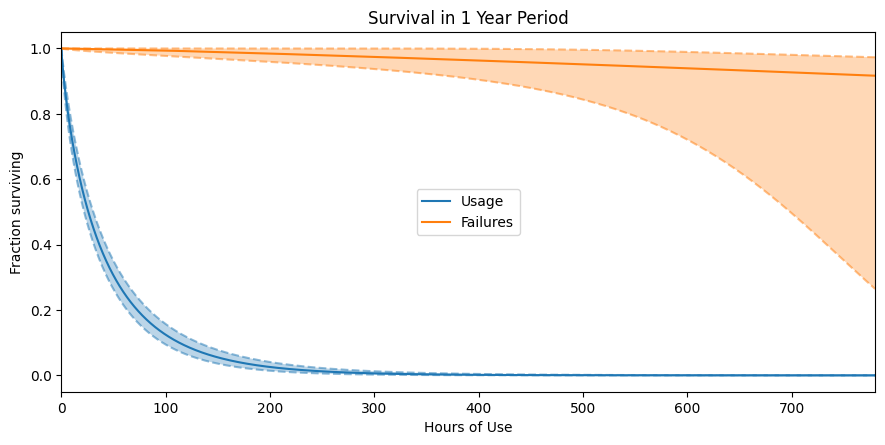

Stress-strength nominal failure = 0.3%
Stress-strength Upper CI failure = 1.4%
Stress-strength Lower CI failure = 0.0%
Reliability Statement for whole period = 3.3% failure rate
Reliability statement for one year = 3.3% failure rate
Stress - Strength Interference
Stress Distribution: Weibull Distribution (α=40.4984,β=0.8133,γ=0.1171)
Strength Distribution: Weibull Distribution (α=5457.6479,β=1.255)
Probability of failure (stress > strength): 0.21404 %


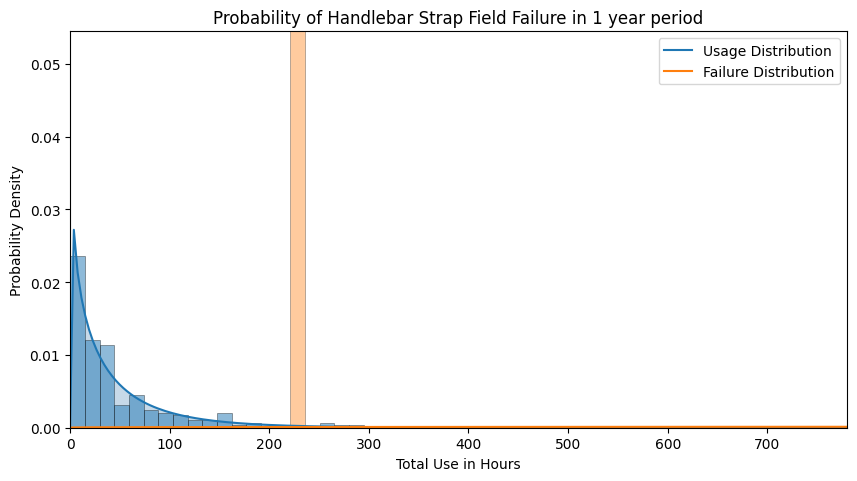

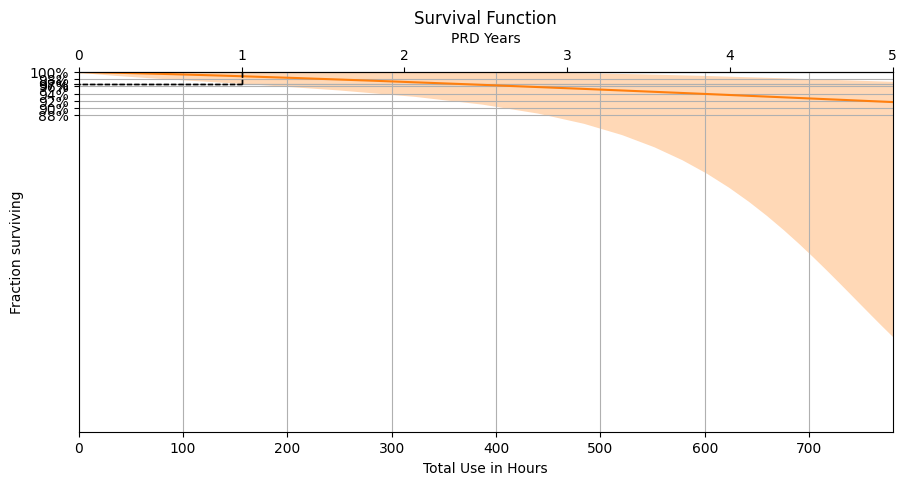

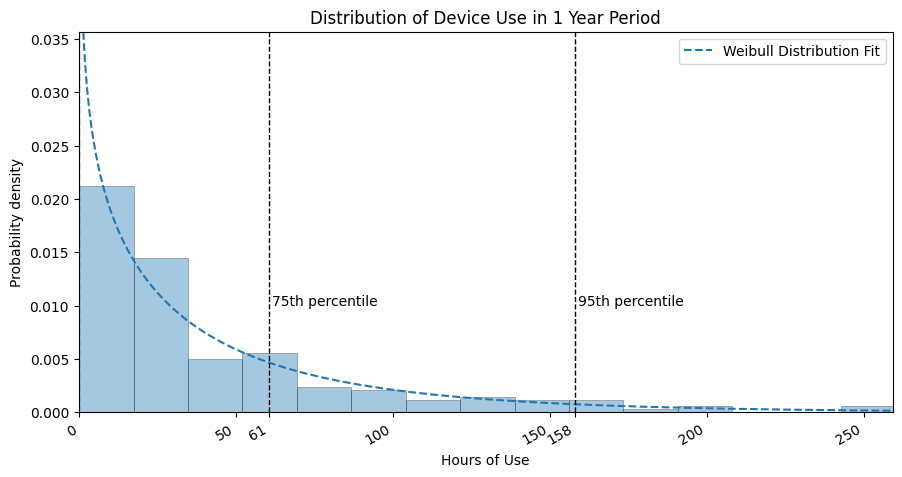

In [23]:
period_in_years=1 #change to years of estimate
prd_hours_per_year = 156
# prd_hours_per_year = test_df["hours_per_year"].quantile(q=0.5)
total_life=5
CI=0.8 #80% two-sided is the same as %90 one-sided

#use
usage=(period_in_years*test_df["hours_per_year"]).tolist()
use_fit = Fit_Weibull_3P(usage,show_probability_plot=False,print_results=False, percentiles=percentiles, CI=0.9)
#plt.show()

#failure
strokes_to_hours=(1./(24*60))
tablet_cycles_to_hours = (1./(3140/780))
ps_cycles_to_hours = (1./(1500/780))

# # Drivetrain / seat slider
strap_failures=(strokes_to_hours*failure_df['failures'].dropna()).tolist()
strap_failures_censored=(strokes_to_hours*failure_df['non-failures'].dropna()).tolist()

# strap_failures=(tablet_cycles_to_hours*failure_df['failures'].dropna()).tolist()
# strap_failures_censored=(tablet_cycles_to_hours*failure_df['non-failures'].dropna()).tolist()
# strap_failures=(ps_cycles_to_hours*failure_df['failures'].dropna()).tolist()
# strap_failures_censored=(ps_cycles_to_hours*failure_df['non-failures'].dropna()).tolist()

# change to how many failures you have
# failure_fit = Fit_Exponential_1P(failures=strap_failures,right_censored=strap_failures_censored,show_probability_plot=False,print_results=False, CI=CI, optimizer='best', percentiles=percentiles, one_sided=True)
failure_fit = Fit_Weibull_2P(failures=strap_failures,right_censored=strap_failures_censored,show_probability_plot=False,print_results=False, CI=CI, optimizer='best', percentiles=percentiles, one_sided=True)
# failure_fit = Fit_Weibull_3P(failures=strap_failures,right_censored=strap_failures_censored,show_probability_plot=False,print_results=False, CI=CI, optimizer='best', percentiles=percentiles, one_sided=True)


stess_strength_extended(use_fit, usage, failure_fit, strap_failures, period_in_years,prd_hours_per_year, total_life)

In [24]:
# failure_df
failure_fit.beta

1.254981848026559

In [ ]:
#test
#test

print(percentiles)
df=use_fit.percentiles
df['SF']=(100-df['Percentile'])/100
print(df.head())


print(interp1d(df['Lower Estimate'], df['SF'], fill_value=(1,0), bounds_error=False))

use_fit.percentiles['Upper Estimate'].iloc[-1]

In [ ]:
period_in_years=1
prd_hours_per_year = 156
CI=0.9

#use
usage=(period_in_years*test_df["hours_per_year"]).tolist()
use_fit = Fit_Weibull_3P(usage,show_probability_plot=False,print_results=False, percentiles=percentiles, CI=CI)

use_fit.distribution.PDF(linestyle='--', label='Weibull Distribution Fit')


line2 = pd.DataFrame (usage)[0].quantile(q=0.75)
line3 = pd.DataFrame (usage)[0].quantile(q=0.95)

plt.axvline(line2, color='k', linestyle='dashed', linewidth=1)
#plt.text(line2+1, 0.01,'percentile = 75, rides/year = %.2f' % line2, rotation=90, fontsize=10)

plt.axvline(line3, color='k', linestyle='dashed', linewidth=1)
#plt.text(line3+1, 0.01,'percentile = 95, rides/year = %.2f' % line3, rotation=90, fontsize=10)

histogram(usage) 
plt.legend()
plt.ylim(0,np.amax(np.histogram(usage,density=True)[0])*2)
#plt.ylim(0,0.022)
plt.xlim(0,300)
plt.xlabel('Hours of Use')
plt.title('Distribution of Device Use in %0.0f Year Period' % period_in_years)